# Chat Executor

In [2]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain langchain_openai tavily-python

In [4]:
import getpass
import os

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API Key:")

OpenAI API Key: ········
Tavily API Key: ········


### We will first define the tools we want to use. For this simple example, we will use create a placeholder search engine. However, it is really easy to create your own tools - see documentation here on how to do that.

In [11]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=1)]

In [13]:
from langgraph.prebuilt import ToolExecutor

tool_executor = ToolExecutor(tools)

C:\Users\deepa\AppData\Local\Temp\ipykernel_2072\780962383.py:3: LangGraphDeprecationWarning: ToolExecutor is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  tool_executor = ToolExecutor(tools)


In [15]:
from langchain_openai import ChatOpenAI

# We will set streaming=True so that we can stream tokens
# See the streaming section for more information on this.
model = ChatOpenAI(temperature=0, streaming=True)

In [17]:
model = model.bind_tools(tools)

# Define the agent state
##### The main type of graph in langgraph is the StateGraph. This graph is parameterized by a state object that it passes around to each node. Each node then returns operations to update that state. These operations can either SET specific attributes on the state (e.g. overwrite the existing values) or ADD to the existing attribute. Whether to set or add is denoted by annotating the state object you construct the graph with.

##### For this example, the state we will track will just be a list of messages. We want each node to just add messages to that list. Therefore, we will use a TypedDict with one key (messages) and annotate it so that the messages attribute is always added to.

In [25]:
import operator
from typing import Annotated, Sequence, TypedDict

from langchain_core.messages import BaseMessage


class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [27]:
## Define the Nodes


from langchain_core.messages import ToolMessage

from langgraph.prebuilt import ToolInvocation


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define the function to execute tools
def call_tool(state):
    messages = state["messages"]
    # Based on the continue condition
    # we know the last message involves a function call
    last_message = messages[-1]
    # We construct an ToolInvocation from the function_call
    tool_call = last_message.tool_calls[0]
    action = ToolInvocation(
        tool=tool_call["name"],
        tool_input=tool_call["args"],
    )
    # We call the tool_executor and get back a response
    response = tool_executor.invoke(action)
    # We use the response to create a FunctionMessage
    function_message = ToolMessage(
        content=str(response), name=action.tool, tool_call_id=tool_call["id"]
    )
    # We return a list, because this will get added to the existing list
    return {"messages": [function_message]}

In [29]:
## Define the graph

from langgraph.graph import END, StateGraph, START

# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", call_tool)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

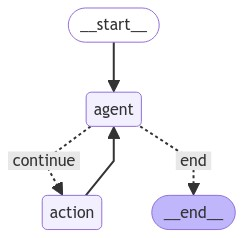

In [31]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [35]:
from langchain_core.messages import HumanMessage

inputs = {"messages": [HumanMessage(content="what is the weather in sf")]}
ans = app.invoke(inputs)

C:\Users\deepa\AppData\Local\Temp\ipykernel_2072\9959494.py:36: LangGraphDeprecationWarning: ToolInvocation is deprecated as of version 0.2.0 and will be removed in 0.3.0. Use langgraph.prebuilt.ToolNode instead.
  action = ToolInvocation(


In [57]:
ans['messages'][3]

AIMessage(content='The current weather in San Francisco is as follows:\n- Temperature: 66.0°F (18.9°C)\n- Condition: Partly cloudy\n- Wind: 15.1 km/h from the west\n- Humidity: 84%\n- Cloud Cover: 75%\n- Visibility: 9.0 miles\n\nFor more detailed information, you can visit [Weather API](https://www.weatherapi.com/).', response_metadata={'finish_reason': 'stop', 'model_name': 'gpt-3.5-turbo-0125'}, id='run-53be3f49-5e09-4309-9fc1-8240520c2b6c-0')